In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import time

from resnet import ResNet50

In [2]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [3]:
train = torchvision.datasets.Imagenette(root="./data", split="train", transform=train_transforms)
train_loader = DataLoader(train, batch_size=128, shuffle=True)

test = torchvision.datasets.Imagenette(
    root="./data", split="val", transform=val_transforms
)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

In [4]:
classes = [
    "tench", "English springer", "cassette player", "chain saw", "church", "French horn", "garbage truck", "gas pump", "golf ball", "parachute"
]

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet50(len(classes))
model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(total_params)

23528586


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=10)

In [8]:
epochs = 10


losses = []
for epoch in range(epochs):
    start_time = time.perf_counter()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch: {epoch} | Loss: {train_loss} | Time: {time.perf_counter() - start_time}")
    losses.append(train_loss)

Epoch: 0 | Loss: 55731.949295043945 | Time: 153.80355819599998
Epoch: 1 | Loss: 122078.52740478516 | Time: 153.69171935200006
Epoch: 2 | Loss: 47745892.14569092 | Time: 153.56323153000005
Epoch: 3 | Loss: 4204028842.8146973 | Time: 153.08886669900005
Epoch: 4 | Loss: 37493298269.71875 | Time: 153.400285146
Epoch: 5 | Loss: 54234677288.0 | Time: 152.99272407199987
Epoch: 6 | Loss: 88111436944.0 | Time: 152.76298134400008
Epoch: 7 | Loss: 732176224992.0 | Time: 152.88485322399993
Epoch: 8 | Loss: 742362486016.0 | Time: 152.78882042200007
Epoch: 9 | Loss: 444457983514.375 | Time: 153.84303009699988


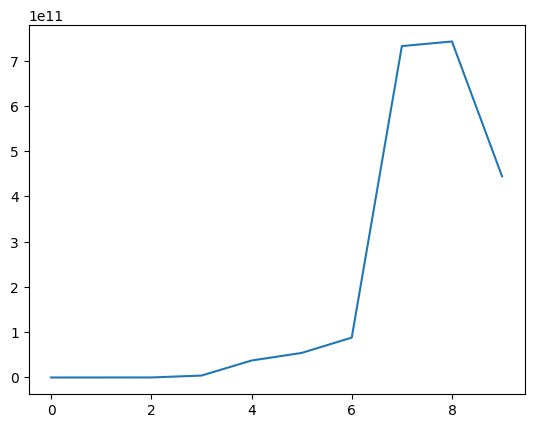

In [9]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [10]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total}")

Accuracy: 12.611464968152866


In [11]:
torch.save(model.state_dict(), "resnet50.pth")